## Z Stack Annotation

Allows a human to annotate what image is focus for a series of Z -stacks

In [1]:
# Parameters
IMG_DIR = r"C:\Users\NikonEclipseTi\Documents\Barracuda\BarracudaQt\focus_data"


In [2]:
# Get a list of all images in a folder
import os
fl_imgs =[]
for file in os.listdir(IMG_DIR):
    if file.endswith(".tiff"):
        if file.find('FL_')>0:
            fl_imgs.append(os.path.join(IMG_DIR, file))

print("There are {} images to analyze".format(len(fl_imgs)))

There are 0 images to analyze


In [2]:
import pandas as pd
import os


In [3]:
df = pd.read_csv(os.path.join(IMG_DIR, 'cell_data.csv'))
df.head()

,Unnamed: 0,Unnamed: 0.1,capillary_z,img_folder,objective_z,slide_movement,well_num,x,y
0,0,0.0,0.1,C:\Users\NikonEclipseTi\Documents\Barracuda\Ba...,6137.875091,False,1,4155.100062,1584.900024
1,1,0.0,0.1,C:\Users\NikonEclipseTi\Documents\Barracuda\Ba...,6148.550092,False,1,4213.300063,1442.000021
2,2,0.0,0.1,C:\Users\NikonEclipseTi\Documents\Barracuda\Ba...,6149.275092,False,1,4281.200064,1327.100020
3,3,0.0,0.1,C:\Users\NikonEclipseTi\Documents\Barracuda\Ba...,6149.875092,False,1,4186.500062,1197.500018
4,4,0.0,0.1,C:\Users\NikonEclipseTi\Documents\Barracuda\Ba...,6150.225092,False,1,4149.900062,1093.900016


In [4]:
len(df.img_folder)

146

In [15]:
import os
# Cycle Through each folder
def grab_images(folder_dir):
    # Get a list of all images in a folder
    folder_path = os.path.join(IMG_DIR, folder_dir)
    imgs =[]
    for file in os.listdir(folder_path):
        if file.endswith(".tiff"):
            imgs.append(os.path.join(folder_path,file))

    print("There are {} images to analyze".format(len(imgs)))
    return imgs
# Grab the 0 Image

def get_pos(name):
    z_pos = name.rsplit('\\')[-1].rstrip('.tiff')[-4:]
    z_pos = int(z_pos)
    return z_pos

def find_image(number,imgs):
    for name in imgs:
        z_pos = get_pos(name)
        if z_pos == number:
            return name
    return False


# Display the 0 Image

import matplotlib.pyplot as plt
from PIL import Image

# Display some Focus Measure 
import cv2
import numpy as np

def get_z_and_focus(imgs):
    z_pos = []
    focus = []
    for img_name in imgs:
        img = Image.open(img_name)
        z_pos.append(get_pos(img_name))
        focus.append(cv2.Laplacian(np.array(img), cv2.CV_16U).var())
    return z_pos, focus

# User Enters 'F' for up,  'D' for down, '' to record position
from matplotlib.widgets import Button
class Correct_Z(object):
    ind = 0
    folder_ind = 0
    
    def start(self):
        Z,F = self.setup_images()

        # Display Image and Focus
        f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]})

        a0.imshow(self.img)
        a1.scatter(Z,F)
        v_line = a1.axvline(self.ind)
        
        #Save a fields

        self.a0=a0
        self.a1=a1
        self.v_line = v_line 
        
        # Allow user to move through the images
        plt.subplots_adjust(bottom=0.1)
        self.axsave = plt.axes([0.59, 0.01, 0.1, 0.045])
        self.axprev = plt.axes([0.7, 0.01, 0.1, 0.045])
        self.axnext = plt.axes([0.81, 0.01, 0.1, 0.045])
        self.bsave = Button(self.axsave, 'Save')
        self.bsave.on_clicked(self.save_changes)
        self.bnext = Button(self.axnext, 'Up')
        self.bnext.on_clicked(self.up)
        self.bprev = Button(self.axprev, 'Down')
        self.bprev.on_clicked(self.down)
        plt.show()
        
    def save_changes(self,event):
        self.img.close()
        for name in self.imgs:
            fold = os.path.dirname(name)
            pos = get_pos(name)
            basename = os.path.basename(name)
            if basename.find('MOD') > 1:
                basename = basename[basename.find('MOD')+3:]
            new_name = '{:+04.0f}-MOD'.format(self.ind+pos)+basename
            os.rename(name, os.path.join(fold, new_name))
        self.next_image()
    
    def next_image(self):
        self.ind=0
        self.folder_ind +=1
        Z,F = self.setup_images()
        self.a1.clear()
        self.a1.scatter(Z,F)
        self.v_line = self.a1.axvline(self.ind)
        self.a0.clear()
        self.a0.imshow(self.img)
    
    def setup_images(self):
         # Get images from each folder
        self.imgs = grab_images(df.img_folder[self.folder_ind])

        # Get 0 image
        img_name=find_image(self.ind,self.imgs)
        self.img = Image.open(img_name)
        
        # Get Focus measure info
        Z,F = get_z_and_focus(self.imgs)
        return Z,F
    
    def move(self):
        
        if np.abs(self.ind)<10:
            return 1
        elif np.abs(self.ind)<25:
            return 3
        elif np.abs(self.ind)<50:
            return 5
        elif np.abs(self.ind)<100:
            return 10
        
    def up(self, event):
        self.img.close()
        a0 = self.a0
        self.ind += self.move()
        a0.clear()
        img_name = find_image(self.ind,self.imgs)
        self.img = Image.open(img_name)
        a0.imshow(self.img)
        self.v_line.set_xdata(self.ind)
        plt.draw()

    def down(self, event):
        self.img.close()
        a0 = self.a0
        self.ind -= self.move()
        a0.clear()
        img_name = find_image(self.ind,self.imgs)
        self.img = Image.open(img_name)
        a0.imshow(self.img)
        self.v_line.set_xdata(self.ind)
        plt.draw()

# Cycles through images and renames them according to new position "{modified_z}_z_stack_{original_z}.tiff"


In [16]:
%matplotlib qt 
z = Correct_Z()
z.start()
plt.show()

There are 49 images to analyze
There are 49 images to analyze


In [ ]:
z.a1.clear()

In [58]:

# Get images from each folder
imgs = grab_images(df.img_folder[0])

# Get 0 image
img_name=find_image(0,imgs)
img = Image.open(img_name)

# Get Focus measure info
Z,F = get_z_and_focus(imgs)

# Display Image and Focus
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]})

a0.imshow(img)
a1.scatter(Z,F)
v_line = a1.axvline(0)


# Allow user to move through the images

from matplotlib.widgets import Button
callback = Position()
plt.subplots_adjust(bottom=0.1)
axprev = plt.axes([0.7, 0.01, 0.1, 0.045])
axnext = plt.axes([0.81, 0.01, 0.1, 0.045])
bnext = Button(axnext, 'Up')
bnext.on_clicked(callback.up)
bprev = Button(axprev, 'Down')
bprev.on_clicked(callback.down)


# User saves, and the images are renamed, Next image is shown 

There are 49 images to analyze


0

In [69]:
# Cycle through images and rename each image
name = imgs[1]
fold = os.path.dirname(name)
name = os.path.basename(name)
if name.find('MOD') > 1:
    name = name[name.find('MOD')+3:]
os.rename(imgs[1], os.path.join(fold, '{:+04.0f}-MOD'+name))


In [79]:
name.find('_')
name[name.find('_')+3:]

'ack_+001.tiff'

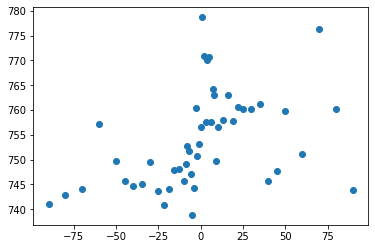

In [20]:
plt.scatter(X[:],Y[:])

In [25]:
n


[(1, 'e'), (2, 'c'), (4, 'b'), (5, 'a'), (6, 'd')]